In [2]:
%matplotlib inline
import os
#code inspired from 
#https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [3]:
from __future__ import print_function
#%matplotlib inline
import argparse
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

#for reproducibility, important for the 
#fixed noise to be the same
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [4]:
dataroot = "/mnt/disks/user/project/bach"
workers = 4
batch_size = 56
image_size = 64 
nc = 1 #color channels, i change to grayscale
nz = 100 #noise vector dim
ngf = 64 #generator feature dim
ndf = 64 #discriminator feature dim
num_epochs =50
lr = 0.0002 #learning rate
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
ngpu = 1

In [5]:
len(os.listdir(dataroot))

3

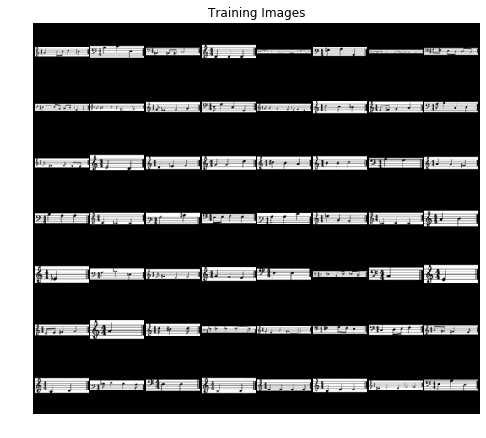

In [6]:
#I use the ImageFolder function which locates images 
#in subfolders and puts them into our dataset.
#mostly modified this from tutorial
dataset = dset.ImageFolder(root=dataroot,
                           #
                           transform=transforms.Compose([
                              transforms.Grayscale(num_output_channels=1), 
                              #note that I load in grayscale
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                              transforms.Normalize([0.5], [0.5]) 
                              #add grayscale & change normalization
                          #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0)\
                      else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],\
                                         padding=2, normalize=True).cpu(),\
                        (1,2,0)))

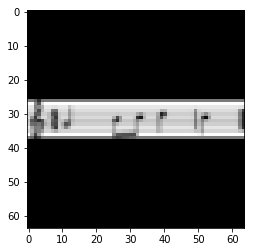

In [7]:
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:1],\
                                         padding=2, normalize=True).cpu(),\
                        (1,2,0)))

In [8]:
#this function allows us to generalize all the weights 
#for the discriminator and generator network. 
#Note that this is different from the generator input 
#which is also generated randomly.
# note that we initialize weights differently for the 
#convolutional layers vs the batch norm layers i.e. 
# for the convolutional layer,we do not need to have a 
#randomly initialized bias
#because we introduce the bias in the batchnorm layers
 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [9]:
#most of this code is from the tutorial but i add the larger image cases
class Generator(nn.Module):
    def __init__(self, ngpu, image_size):
        super(Generator, self).__init__()
        self.ngpu = ngpu 
        if image_size==64: # i defined separate networks for the 
        #64 and 128 dim image cases so we
        # can easily try both without constantly changing the 
        #dimensions of our layers
          self.main = nn.Sequential(
              nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
              nn.BatchNorm2d(ngf * 8),
              nn.ReLU(True),

              nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
              nn.BatchNorm2d(ngf * 4),
              nn.ReLU(True),

              nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
              nn.BatchNorm2d(ngf * 2),
              nn.ReLU(True),
    
              nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
              nn.BatchNorm2d(ngf),
              nn.ReLU(True),

              nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False), 
              nn.Tanh()
          )
        elif image_size ==128:
            self.main = nn.Sequential(
                
              nn.ConvTranspose2d( nz, ngf * 16, 4, 1, 0, bias=False),
              nn.BatchNorm2d(ngf * 16),
              nn.ReLU(True),

              nn.ConvTranspose2d( ngf * 16, ngf * 8, 4, 2, 1, bias=False),
              nn.BatchNorm2d(ngf * 8),
              nn.ReLU(True),

              nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
              nn.BatchNorm2d(ngf * 4),
              nn.ReLU(True),

              nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
              nn.BatchNorm2d(ngf * 2),
              nn.ReLU(True),
    
              nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
              nn.BatchNorm2d(ngf),
              nn.ReLU(True),

              nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False), #because input
              nn.Tanh() #tanh activation (so the output will be between 1 and -1)
          )
              



    def forward(self, input):
        return self.main(input)

In [10]:
netG = Generator(ngpu, image_size).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
    #i only use one GPU

netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [3]:
#most of this code is from the tutorial but i add the 128x128 case
class Discriminator(nn.Module):
    def __init__(self, ngpu, image_size): #added image_size param for ease 
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        if image_size==64:
          self.main = nn.Sequential(
              nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
              nn.LeakyReLU(0.2, inplace=True),

              nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
              nn.BatchNorm2d(ndf * 2),
              nn.LeakyReLU(0.2, inplace=True),

              nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
              nn.BatchNorm2d(ndf * 4),
              nn.LeakyReLU(0.2, inplace=True),

              nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
              nn.BatchNorm2d(ndf * 8),
              nn.LeakyReLU(0.2, inplace=True),

              nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
              nn.Sigmoid()
          )
        elif image_size == 128:
          self.main = nn.Sequential(
              nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
              nn.LeakyReLU(0.2, inplace=True),

              # nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
              # nn.BatchNorm2d(ndf * 2),
              # nn.LeakyReLU(0.2, inplace=True),

              # nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
              # nn.BatchNorm2d(ndf * 4),
              # nn.LeakyReLU(0.2, inplace=True), #the layers i removed to
              #speed up computation are commented out

              nn.Conv2d(ndf, ndf * 2, 4, 4, 1, bias=False),
              nn.BatchNorm2d(ndf * 2),
              nn.LeakyReLU(0.2, inplace=True),

              # nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
              # nn.BatchNorm2d(ndf * 8),
              # nn.LeakyReLU(0.2, inplace=True),

              # nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
              # nn.BatchNorm2d(ndf * 16),
              # nn.LeakyReLU(0.2, inplace=True), 
              #those commented out are the removed layers or 
              #computational eff.
              nn.Conv2d(ndf * 2, ndf * 4, 4, 4, 1, bias=False),
              nn.BatchNorm2d(ndf * 4),
              nn.LeakyReLU(0.2, inplace=True),

              nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
              nn.Sigmoid()
          )



    def forward(self, input):
        return self.main(input)

In [12]:
#most of this code is from the tutorial
netD = Discriminator(ngpu, image_size).to(device)


if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [13]:
#most of this code is from the tutorial
criterion = nn.BCELoss()

#latent vector for input into generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 0.95
fake_label = 0.05# smoothing labels

optimizerD = optim.Adam(netD.parameters(), lr=lr/2, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


In [1]:
#you do not see outputs because i removed it for submission
def return_model_for_training(directory, epoch, image_size): 
  #wrote this function to continue training if i stop at some epoch
      netG = Generator(ngpu, image_size).to(device)

      if (device.type == 'cuda') and (ngpu > 1):
          netG = nn.DataParallel(netG, list(range(ngpu)))

      netG.apply(weights_init)

      netD = Discriminator(ngpu, image_size).to(device)

      if (device.type == 'cuda') and (ngpu > 1):
          netD = nn.DataParallel(netD, list(range(ngpu)))
      
      netD.apply(weights_init)

      state_dictG = torch.load(directory +"/netG{}".format(epoch))
      state_dictD = torch.load(directory +"/netD{}".format(epoch))

      netG.load_state_dict(state_dictG)
      netD.load_state_dict(state_dictD)
      return netG, netD# # Training Loop #most of this code is from the tutorial
from timeit import default_timer
time_st = default_timer()
from PIL import Image

latest =0
# netG, netD = return_model_for_training\
# ("GAN-Image-FolderOri",\
#  latest, image_size)
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward propagation
        output = netD(real_cpu).view(-1)
        # loss
        errD_real = criterion(output, label)
        # gradients
        errD_real.backward()
        D_x = output.mean().item()

        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        netG.zero_grad()
        label.fill_(real_label) 
        # forward pass through D
        output = netD(fake).view(-1)
        # loss
        errG = criterion(output, label)
        # gradients
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update
        optimizerG.step()
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x):\
             %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # save losses
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if (epoch % 5 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        #i add code to save models every x epochs (set to 1 now)
        if (epoch % 1 == 0): 
          torch.save(netG.state_dict(), \
                     "GAN-Image-FolderOri/netG{}".\
                     format(epoch+latest+1))
          torch.save(netD.state_dict(), \
                     "GAN-Image-FolderOri/netD{}".\
                     format(epoch+latest+1))
        iters += 1

print(default_timer()-time_st)



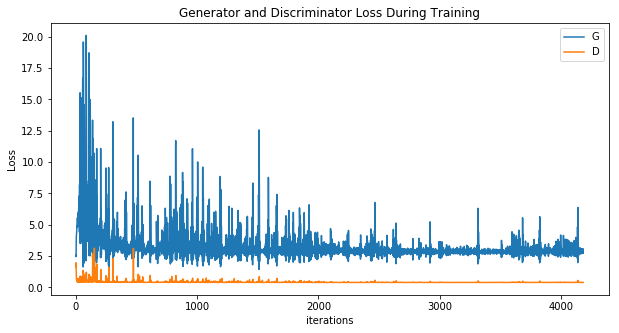

In [23]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
real_batch = next(iter(dataloader))

# real
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64],\
                                         padding=5, normalize=True).cpu(),\
                        (1,2,0)))

# fake from last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()
#e12

In [15]:
#i wrote this function to allow me to look at fake images generated by
# old stored models
def get_fake_for_specific_model(directory, image_size):
  lossG = []
  lossD = []
  fake_images = []
  for epoch in range(1, int(len(os.listdir(directory))/2)):
    if epoch%1==0:
      netG = Generator(ngpu, image_size).to(device)

      if (device.type == 'cuda') and (ngpu > 1):
          netG = nn.DataParallel(netG, list(range(ngpu)))

      netG.apply(weights_init)

      netD = Discriminator(ngpu, image_size).to(device)

      if (device.type == 'cuda') and (ngpu > 1):
          netD = nn.DataParallel(netD, list(range(ngpu)))
        
      netD.apply(weights_init)

      #we load saved models, we have try and except because 
      #the last epoch
      #is often incomplete because I interrupt it
      try:
        state_dictG = torch.load(directory +"/netG{}".format(epoch))
        state_dictD = torch.load(directory +"/netD{}".format(epoch))
      except RuntimeError:
        print(epoch)
        next
      netG.load_state_dict(state_dictG)
      netD.load_state_dict(state_dictD)

      #noise
      fixed_noise = torch.randn(61, nz, 1, 1, device=device)
      with torch.no_grad():
          #make fake batch
          fake = netG(fixed_noise).detach().cpu()
          fake_images.append(fake)
          # break
      del netG
      del netD
  return fake_images
      
#only visualize every epoch
# we can choose which directory we want to visualize fakes

directory = "GAN-Image-FolderOri"
fake_images = get_fake_for_specific_model(directory, image_size)

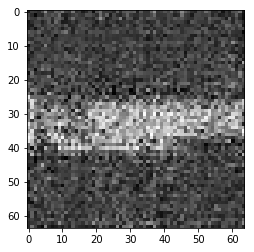

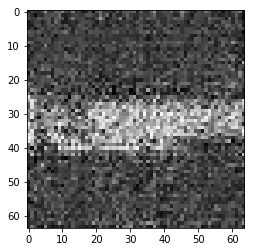

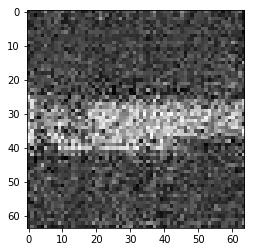

In [16]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(vutils.make_grid(fake_images[-1][16], padding=2,\
                                         normalize=True), (1, 2, 0)))
plt.show()
plt.imshow(np.transpose(vutils.make_grid(fake_images[-1][10], padding=2, \
                                         normalize=True), (1, 2, 0)))
plt.show()
plt.imshow(np.transpose(vutils.make_grid(fake_images[-1][30], padding=2, \
                                         normalize=True), (1, 2, 0)))
plt.show()

In [1]:
# for i in range(len(fake_images)):
#   plt.imshow(np.transpose(vutils.make_grid(fake_images[i], \
#                                            padding=2, normalize=True)\
#                           , (1, 2, 0)))
#   plt.title("epoch {}".format(i))
#   plt.show()
# #downloaded these images and used online tool to make the gifs in report